In [1]:
# import necessary libraries
import skimage as ski
import pandas as pd 
import os 
from skimage.transform import resize 
from skimage.io import imread 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn import svm 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage import exposure

In [2]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
# list all the folders in the train directory
Categories = os.listdir('train/')

In [13]:
flat_data_arr=[] #input array 
target_arr=[] #output array 
datadir ='train/'
#path which contains all the categories of images 
for i in Categories: 
    print(f'loading... category : {i}') 
    path=os.path.join(datadir,i) 
    for img in os.listdir(path): 
        img_array=imread(os.path.join(path,img)) 
        # img_array=rgb2gray(img_array)
        # img_resized_threshold = threshold_otsu(img_array)
        # gamma_corrected = exposure.adjust_gamma(img_resized_threshold, 2)
        img_resized=resize(img_array,(96,96,3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(Categories.index(i)) 
    print(f'loaded category:{i} successfully') 
flat_data=np.array(flat_data_arr) 
target=np.array(target_arr)


loading... category : A
loaded category:A successfully
loading... category : B
loaded category:B successfully
loading... category : C
loaded category:C successfully
loading... category : D
loaded category:D successfully
loading... category : E
loaded category:E successfully
loading... category : F
loaded category:F successfully
loading... category : G
loaded category:G successfully
loading... category : H
loaded category:H successfully
loading... category : I
loaded category:I successfully
loading... category : K
loaded category:K successfully
loading... category : L
loaded category:L successfully
loading... category : M
loaded category:M successfully
loading... category : N
loaded category:N successfully
loading... category : O
loaded category:O successfully
loading... category : P
loaded category:P successfully
loading... category : Q
loaded category:Q successfully
loading... category : R
loaded category:R successfully
loading... category : S
loaded category:S successfully
loading...

In [14]:
from sklearn.decomposition import PCA
num_features = 10  # Number of features to extract
pca = PCA(n_components=num_features)  # PCA for feature extraction
# Perform PCA to extract 10 features
pca.fit(flat_data)
flat_data_pca = pca.transform(flat_data)

In [28]:
import numpy as np
from sklearn.decomposition import PCA


# Save PCA model and parameters
import pickle
pickle.dump(pca, open('pca_model.pkl', 'wb'))


In [15]:
#dataframe 
df=pd.DataFrame(flat_data_pca) 
df['Target']=target 
# store the df in compressed format like hdf5
df.to_hdf('feature_data.h5', 'df', mode='w')


In [3]:
# df = pd.read_hdf('feature_data.h5', 'df')

In [16]:
# 1. Divide dataframe into input and output
x = df.drop(columns=['Target']) # Drop the column to be predicted
y = df['Target'] # Choose Output column to be predicted
feature_names = x.columns

In [17]:
# Splitting the data into training and testing sets 
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20, 
											random_state=77, 
											stratify=y)


In [9]:
# # Defining the parameters grid for GridSearchCV 
# param_grid={'C':[0.1,1,10,100], 
# 			'gamma':[0.0001,0.001,0.1,1], 
# 			'kernel':['rbf','poly']} 

# # Creating a support vector classifier 
# svc=svm.SVC(probability=True) 

# # Creating a model using GridSearchCV with the parameters grid 
# model=GridSearchCV(svc,param_grid)


In [18]:
model = svm.SVC(probability=True)

In [19]:
# Training the model using the training data 
model.fit(x_train,y_train)

SVC(probability=True)

In [37]:
# Save Model Using Pickle
import pickle
filename = 'svm_model.pkl'
pickle.dump(model, open(filename, 'wb'))


# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

0.963819095477387


In [34]:
# Testing the model using the testing data 
y_pred = model.predict(x_test) 

# Calculating the accuracy of the model 
accuracy = accuracy_score(y_pred, y_test) 

# Print the accuracy of the model 
print(f"The model is {accuracy*100}% accurate")

The model is 96.3819095477387% accurate


In [46]:
# Read and preprocess a new image
new_image_path = 'download.jpg'
target_img_array=imread(new_image_path)
target_img_resized=resize(target_img_array,(96,96,3))
target_img_flatten = target_img_resized.flatten()

# Load saved PCA model
saved_pca = pickle.load(open("pca_model.pkl", 'rb'))

# Subtract mean and project onto eigenvectors
mean_vector = saved_pca.mean_
eigenvectors = saved_pca.components_
centered_image = target_img_flatten - mean_vector
pca_transformed = np.dot(centered_image, eigenvectors.T)

# reshape the pca_transformed array
pca_transformed = pca_transformed.reshape(1, -1)

# # Now pca_transformed contains the PCA-transformed features of the new image
# target_pred = model.predict(pca_transformed) 
# target_pred = Categories[target_pred[0]]
# target_pred


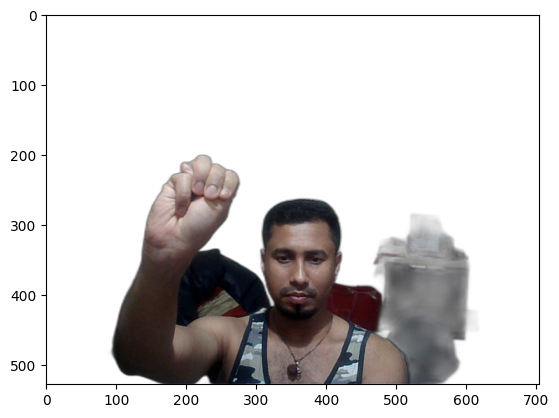

In [43]:
import cv2
import numpy as np
from skimage.transform import resize
from skimage.io import imread
from rembg import remove 
from PIL import Image 

testimg = Image.open("download.jpg")
    
testimg = remove(testimg) 

# isolate the hand from the image



# show the image
plt.imshow(testimg)

In [47]:
probability=model.predict_proba(pca_transformed)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[model.predict(pca_transformed)[0]])

A = 33.176992313125126%
B = 13.977049433896616%
C = 6.268045759053802%
D = 0.7405047593424476%
E = 5.688168586231244%
F = 1.791695054776904%
G = 4.107190707242099%
H = 0.5884244532297651%
I = 1.4006317796490655%
K = 1.43594992674353%
L = 0.7242328019614471%
M = 4.084640235424312%
N = 3.242862285807873%
O = 3.18709477342065%
P = 2.859746089590014%
Q = 1.6292720721710514%
R = 1.403890162026742%
S = 1.9633065429846337%
T = 5.65940216489786%
U = 0.5097857462629943%
V = 0.47936902964662387%
W = 0.4541075002776135%
X = 0.75601577492403%
Y = 3.871622047313584%
The predicted image is : A
